<a href="https://colab.research.google.com/github/angeloBuso/Dash_Streamlit_Ocorrencias_Aereas/blob/master/AcidentesAereoApoio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img alt="Imagem" width="100%" src="https://raw.githubusercontent.com/angeloBuso/angeloBuso/main/image/Imagem2-notebook.png">

---
# Investigando os dados de acidentes Aéreos

Fazendo um *google* na seguinte pergunta, "qual é o transporte mais seguro do mundo?", pelo menos em 16/03/2021 obtemos mais de 86 mil respostas e o meio de transporte **avião** destaca nesta pesquisa como sendo um dos mais seguro, se não o mais.

<img alt="Imagem" width="100%" src="https://github.com/angeloBuso/Dash_Streamlit_Ocorrencias_Aereas/blob/master/image/airplane-sunset.jpg?raw=true">


Sendo assim, seria muito interessante se conseguissemos fazer uma análise exploratória das possíveis ocorrências aéreas aqui no Brasil. Pesquisando identificamos que existe um orgão do Comando da Aeronáutica que é responsável pelas atividades de investigação de acidentes aeronáuticos da aviação civil e da Força Aérea Brasileira, o [CENIPA](https://https://www2.fab.mil.br/cenipa/index.php/o-cenipa). Segundo o orgão,

> "é da análise técnico-científica do acidente ou incidente aeronáutico que se retiram valiosos ensinamentos. Esse aprendizado, transformado em linguagem apropriada, é traduzido em recomendações de segurança específicas e objetivas para os fatos analisados..."

Então nosso objetivo é buscar esses dados compreender e preprará-los no propósito de construir um **Dashboard**, usando apenas Python, que permitirá usar (i.) filtros por ano e (ii.) e por tipo de categoria das ocorrências, dando interatividade para usuários e fornecendo informações. Visualizaremos um mapa com as quantidades de ocorrencia registradas indicando a região do ocorrido. Bora lá?!



---





## 1. Compreensão Problema de Negócio

Uma boa prática na construção de dashboard's é construir uma função **Pipeline** com os *steps* de ETL, ou seja, alguns tratamentos para o conjunto de dados, com vistas a finalidade que porpomos. Utilizaremos esse *notebook* como ferramenta de apoio para a construção do dashboard, o qual:

1.   Carregaremos os conjuntos de dados.
2.   *Feature Selection*, selecionaremos apenas os atributos importantes para o Dash.
1.   Alteraremos títulos das label, padronizando a nomeclatura.
2.   Padronizaremos o atributo `data` e `hora` para o formato `dateTime`
1.   Identificaremos possíveis pontos de dados de `longitude` e `latitude` que não estão no solo brasileiro.
1.   Aplicaremos filtros no conjunto de dados processados.

O output deste Pipeline alimentará a aplicação do nosso dashboard. O processo de *ETL* vai muito além dos passos mencionados acima, no entanto para nossa tarefa será suficiente.

In [1]:
# importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import RendererAgg
import seaborn as sns
import folium
from folium import plugins
%matplotlib inline

## 2. Obtenção dos Dados

Os dados para a presente análise, foram extraídos do repositório da [CENIPA](https://dados.gov.br/dataset/ocorrencias-aeronauticas-da-aviacao-civil-brasileira) (Centro de Investigação e Prevenção de Acidentes Aeronáuticos). É o órgão do Comando da Aeronáutica responsável pelas atividades de investigação de acidentes aeronáuticos da aviação civil e da Força Aérea Brasileira.

Os dados são de domínio público, fazem parte do projeto *Opendata AIG Brazil*, constam nesta base de dados as ocorrências aeronáuticas notificadas ao CENIPA nos últimos 10 anos (2010 - 2020) que ocorreram em solo brasileiro. São resguardadas a privacidade de pessoas físicas/jurídicas envolvidas conforme previsto pela Lei de Acesso à Informação (Lei n° 12.527, de 18 de novembro de 2011).

Os dados foram baixados em 09/03/2021 e disponibilizados no meu repositório do [GitHub](https://github.com/angeloBuso/Dash_Streamlit_Ocorrencias_Aereas/tree/master/dataSet).

### 2.1 Carga dos dados

In [2]:
ocorrencia = 'https://raw.githubusercontent.com/angeloBuso/Dash_Streamlit_Ocorrencias_Aereas/master/dataSet/ocorrencia_2010_2020_lat_lon_etl.csv'
aeronave = 'https://raw.githubusercontent.com/angeloBuso/Dash_Streamlit_Ocorrencias_Aereas/master/dataSet/aeronave_2010_2020.csv'
ocorrencia_tp = 'https://raw.githubusercontent.com/angeloBuso/Dash_Streamlit_Ocorrencias_Aereas/master/dataSet/ocorrencia_tipo_2010_2020.csv'

**Os** dados que iremos trabalhar, estão contemplados em 3 base de dados do Cenipa. Iremos realizar um processo de ELT, no intuido de obter um dataSet com as informações que necessitaremos para construir o dashboard.

A manipulação dos dados se dará com base no modelos de dados disponibilizados pelo [Cenipa](http://sistema.cenipa.aer.mil.br/cenipa/media/opendata/modelo_dados.png).

<img alt="Imagem" width="50%" src="https://github.com/angeloBuso/Dash_Streamlit_Ocorrencias_Aereas/blob/master/image/modelo_dados.png?raw=true">


## 3. Análise Exploratória dos Dados

Visão geral dos *dataSet's* que iremos realizar processo de *ETL* (tratamento e limpeza dos dados)

### 3.1 Tabela Ocorrências
Onde estão registrados as ocorrências aeronáuticas notificadas ao CENIPA, que ocorreram em solo brasileiro.

In [3]:
df1= pd.read_csv(ocorrencia, sep= ';')
print("\nNesta tabela temos {} colunas e {} linhas/registros."\
          .format(df1.shape[1], df1.shape[0]))
df1.head()


Nesta tabela temos 22 colunas e 5752 linhas/registros.


,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
0,40211,40211,40211,40211,40211,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,****,03/01/2010,12:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
1,40349,40349,40349,40349,40349,INCIDENTE,NaN,NaN,BELÉM,PA,BRASIL,SBBE,03/01/2010,11:05:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO
2,40351,40351,40351,40351,40351,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,SBRJ,03/01/2010,03:00:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO
3,39527,39527,39527,39527,39527,ACIDENTE,-13.106667,-55.993056,LUCAS DO RIO VERDE,MT,BRASIL,****,04/01/2010,17:30:00,SIM,FINALIZADA,A-539/CENIPA/2018,SIM,28/10/2019,0,1,NÃO
4,40324,40324,40324,40324,40324,INCIDENTE,NaN,NaN,PELOTAS,RS,BRASIL,SBPK,05/01/2010,19:25:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO


Na tabela `Ocorrência` nota-se, em sua maioria, de atributos categóricas, que por sua vez, é bastante útil para construção de Dashboards. Podemos ainda notar valores faltantes nos atributos `ocorrencia_latitude` e `ocorrencia_longitude` como faremos um mapa esses atributos foram tratados a parte.

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5752 entries, 0 to 5751
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   codigo_ocorrencia               5752 non-null   int64  
 1   codigo_ocorrencia1              5752 non-null   int64  
 2   codigo_ocorrencia2              5752 non-null   int64  
 3   codigo_ocorrencia3              5752 non-null   int64  
 4   codigo_ocorrencia4              5752 non-null   int64  
 5   ocorrencia_classificacao        5752 non-null   object 
 6   ocorrencia_latitude             3630 non-null   float64
 7   ocorrencia_longitude            3629 non-null   float64
 8   ocorrencia_cidade               5752 non-null   object 
 9   ocorrencia_uf                   5752 non-null   object 
 10  ocorrencia_pais                 5752 non-null   object 
 11  ocorrencia_aerodromo            5752 non-null   object 
 12  ocorrencia_dia                  57

### 3.2 Tabela Aeronave
Onde estão registrados as informações sobre as aeronaves envolvidas nas ocorrências aeronáuticas notificadas ao CENIPA, que ocorreram em solo brasileiro.

In [5]:
df2 = pd.read_csv(aeronave, sep= ';')
print("\nNesta tabela temos {} colunas e {} linhas/registros."\
          .format(df2.shape[1], df2.shape[0]))
df2.head()


Nesta tabela temos 23 colunas e 5821 linhas/registros.


,codigo_ocorrencia2,aeronave_matricula,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_pmd_categoria,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total
0,39115,PTNQX,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-711A,P28R,PISTÃO,MONOMOTOR,1202,1202,4.0,1979.0,BRASIL,BRASIL,AVIÃO,PARTICULAR,BRIGADEIRO ARARIPE MACEDO,CORRENTINA,DECOLAGEM,PRIVADA,SUBSTANCIAL,0
1,39155,PTLVI,***,AVIÃO,BEECH AIRCRAFT,C90,BE9L,TURBOÉLICE,BIMOTOR,4377,4377,8.0,1979.0,BRASIL,BRASIL,AVIÃO,PARTICULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,PRIVADA,NENHUM,0
2,39156,PPPTO,***,AVIÃO,AEROSPATIALE AND ALENIA,ATR-72-212A,AT72,TURBOÉLICE,BIMOTOR,22500,22500,73.0,2008.0,BRASIL,BRASIL,AVIÃO,REGULAR,AFONSO PENA,ADALBERTO MENDES DA SILVA,ARREMETIDA NO AR,REGULAR,LEVE,0
3,39158,PRLGJ,REGULAR,AVIÃO,BOEING COMPANY,757-225,B752,JATO,BIMOTOR,108862,108862,5.0,1984.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,SUBIDA,REGULAR,NENHUM,0
4,39176,PRMAA,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-232,A320,JATO,BIMOTOR,77000,77000,184.0,2001.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,SUBIDA,REGULAR,NENHUM,0


Na tabela `Areonave` também observamos a presença, em sua maioria, de atributos categóricas, que por sua vez, é bastante útil para construção de Dashboards.

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   codigo_ocorrencia2           5821 non-null   int64  
 1   aeronave_matricula           5821 non-null   object 
 2   aeronave_operador_categoria  5821 non-null   object 
 3   aeronave_tipo_veiculo        5821 non-null   object 
 4   aeronave_fabricante          5821 non-null   object 
 5   aeronave_modelo              5821 non-null   object 
 6   aeronave_tipo_icao           5821 non-null   object 
 7   aeronave_motor_tipo          5821 non-null   object 
 8   aeronave_motor_quantidade    5821 non-null   object 
 9   aeronave_pmd                 5821 non-null   int64  
 10  aeronave_pmd_categoria       5821 non-null   int64  
 11  aeronave_assentos            5670 non-null   float64
 12  aeronave_ano_fabricacao      5671 non-null   float64
 13  aeronave_pais_fabr

### 3.3 Tabela Tipo de Ocorrência
Onde estão registrados os tipos de ocorrências notificadas ao CENIPA, que ocorreram em solo brasileiro.

In [7]:
df3 = pd.read_csv(ocorrencia_tp, sep=';')
print("\nNesta tabela temos {} colunas e {} linhas/registros."\
          .format(df2.shape[1], df2.shape[0]))
df3.head()


Nesta tabela temos 23 colunas e 5821 linhas/registros.


,codigo_ocorrencia1,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao
0,39115,PANE SECA,COMBUSTÍVEL | PANE SECA,FUEL
1,39155,VAZAMENTO DE COMBUSTÍVEL,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
2,39156,FOGO EM VOO,FOGO/FUMAÇA (SEM IMPACTO) | FOGO EM VOO,F-NI
3,39158,SUPERAQUECIMENTO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | SUPERAQU...,SCF-PP
4,39176,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP


Tabela `Tipo de Ocorrêcnia` predominantemente de atributos categóricos.


In [8]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5884 entries, 0 to 5883
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   codigo_ocorrencia1         5884 non-null   int64 
 1   ocorrencia_tipo            5884 non-null   object
 2   ocorrencia_tipo_categoria  5884 non-null   object
 3   taxonomia_tipo_icao        5884 non-null   object
dtypes: int64(1), object(3)
memory usage: 184.0+ KB


Observamos que não possuímos valores missing (quantidade de valores `Non-Null` - não nulos) nas 3 tabelas carregadas. Prosseguiremos na junção das 3 tabelas em um dataSet único.

### 3.4 Dados combinados

#### 3.4.1 Adicionando tipo de ocorrências
Agrupando a  `tabela ocorrência` com os tipos de ocorrências, que estão na `tabela tipo de ocorrência`, o *output* iremos instanciar um novo dataSet.

In [9]:
df4= pd.merge(df1,df3, how= 'left', on= 'codigo_ocorrencia1')
df4.head()

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao
0,40211,40211,40211,40211,40211,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,****,03/01/2010,12:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO,TRÁFEGO AÉREO,PERDA DE SEPARAÇÃO / COLISÃO EM VOO | TRÁFEGO ...,MAC
1,40349,40349,40349,40349,40349,INCIDENTE,NaN,NaN,BELÉM,PA,BRASIL,SBBE,03/01/2010,11:05:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,BIRD
2,40351,40351,40351,40351,40351,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,SBRJ,03/01/2010,03:00:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,BIRD
3,39527,39527,39527,39527,39527,ACIDENTE,-13.106667,-55.993056,LUCAS DO RIO VERDE,MT,BRASIL,****,04/01/2010,17:30:00,SIM,FINALIZADA,A-539/CENIPA/2018,SIM,28/10/2019,0,1,NÃO,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,LALT
4,40324,40324,40324,40324,40324,INCIDENTE,NaN,NaN,PELOTAS,RS,BRASIL,SBPK,05/01/2010,19:25:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,OUTROS,OUTROS,OTHR


In [10]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5884 entries, 0 to 5883
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   codigo_ocorrencia               5884 non-null   int64  
 1   codigo_ocorrencia1              5884 non-null   int64  
 2   codigo_ocorrencia2              5884 non-null   int64  
 3   codigo_ocorrencia3              5884 non-null   int64  
 4   codigo_ocorrencia4              5884 non-null   int64  
 5   ocorrencia_classificacao        5884 non-null   object 
 6   ocorrencia_latitude             3754 non-null   float64
 7   ocorrencia_longitude            3753 non-null   float64
 8   ocorrencia_cidade               5884 non-null   object 
 9   ocorrencia_uf                   5884 non-null   object 
 10  ocorrencia_pais                 5884 non-null   object 
 11  ocorrencia_aerodromo            5884 non-null   object 
 12  ocorrencia_dia                  58

#### 3.4.2 Adicionando informações das aeronaves
Inserindo as informações das aeronaves, contidas na  `tabela aeronave` no nosso novo conjunto de dados.

In [11]:
df5 = pd.merge(df4, df2, how= 'left', on= 'codigo_ocorrencia2')
print("\nNossos dados combinados, temos {} colunas e {} linhas/registros."\
          .format(df5.shape[1], df5.shape[0]))
df5.head()


Nossos dados combinados, temos 47 colunas e 5953 linhas/registros.


,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao,aeronave_matricula,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_pmd_categoria,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total
0,40211,40211,40211,40211,40211,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,****,03/01/2010,12:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO,TRÁFEGO AÉREO,PERDA DE SEPARAÇÃO / COLISÃO EM VOO | TRÁFEGO ...,MAC,PRCHE,TÁXI AÉREO,HELICÓPTERO,SIKORSKY AIRCRAFT,S-76C,S76,TURBOEIXO,BIMOTOR,5307,5307,14.0,2007.0,BRASIL,BRASIL,HELICÓPTERO,TÁXI AÉREO,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,TÁXI AÉREO,NENHUM,0
1,40349,40349,40349,40349,40349,INCIDENTE,NaN,NaN,BELÉM,PA,BRASIL,SBBE,03/01/2010,11:05:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,BIRD,PRMAB,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-232,A320,JATO,BIMOTOR,70000,70000,184.0,2001.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,REGULAR,LEVE,0
2,40351,40351,40351,40351,40351,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,SBRJ,03/01/2010,03:00:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,BIRD,PRMBW,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A319-132,A319,JATO,BIMOTOR,75500,75500,154.0,2008.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,INDETERMINADA,REGULAR,LEVE,0
3,39527,39527,39527,39527,39527,ACIDENTE,-13.106667,-55.993056,LUCAS DO RIO VERDE,MT,BRASIL,****,04/01/2010,17:30:00,SIM,FINALIZADA,A-539/CENIPA/2018,SIM,28/10/2019,0,1,NÃO,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,LALT,PTURT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,IPAN,PISTÃO,MONOMOTOR,1800,1800,1.0,2004.0,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0
4,40324,40324,40324,40324,40324,INCIDENTE,NaN,NaN,PELOTAS,RS,BRASIL,SBPK,05/01/2010,19:25:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,OUTROS,OUTROS,OTHR,PPPSB,REGULAR,AVIÃO,EMBRAER,EMB-120ER,E120,TURBOÉLICE,BIMOTOR,11990,11990,34.0,1995.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,TÁXI,REGULAR,NENHUM,0


In [12]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5953 entries, 0 to 5952
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   codigo_ocorrencia               5953 non-null   int64  
 1   codigo_ocorrencia1              5953 non-null   int64  
 2   codigo_ocorrencia2              5953 non-null   int64  
 3   codigo_ocorrencia3              5953 non-null   int64  
 4   codigo_ocorrencia4              5953 non-null   int64  
 5   ocorrencia_classificacao        5953 non-null   object 
 6   ocorrencia_latitude             3795 non-null   float64
 7   ocorrencia_longitude            3794 non-null   float64
 8   ocorrencia_cidade               5953 non-null   object 
 9   ocorrencia_uf                   5953 non-null   object 
 10  ocorrencia_pais                 5953 non-null   object 
 11  ocorrencia_aerodromo            5953 non-null   object 
 12  ocorrencia_dia                  59

In [13]:
#df5.loc[df5['codigo_ocorrencia']==78904]
#df5.codigo_ocorrencia.value_counts().loc[lambda x : x>1]

Os dados já combinados, contendo todas as informações para resolver o **Problema de negócio** proposto pelo projeto, mostrou-se possuir dados em sua maioria do tipo categórico, ou seja, os registros desses atributos correspondem à classes em que pertencem. Esses tipos de variáveis são conhecidas como **variáveis Qualitativas** e são perfeitas para construção de visuais (dashboard's) pois os registros qualificam a informação.

## 4. Pré Processamento dos dados
Nesta etapa realizaremos *Feature selection*, ou seja, seleção de atributos. Após um processo de exploração nos dados, identificamos quais variáveis **qualitativas** iremos utilizar para a construção do nosso visual.

### 4.1 Definição *índice* dos dados
O atributo `codigo_ocorrencia` é o que podemos considerar nossa *primary key*, ou seja, o atributo único que permite combinar as tabelas, esta presente em todas as tabelas, seria o `ID` da ocorrência, conforme mostra no modelo de dados fornecido pela Instituição e apresetada no início desse jupyter. Sendo assim, a definiremos como o índice de nossos dados.

In [14]:
df5.index= df5['codigo_ocorrencia']
df5.head()

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao,aeronave_matricula,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_pmd_categoria,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total
codigo_ocorrencia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40211,40211,40211,40211,40211,40211,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,****,03/01/2010,12:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO,TRÁFEGO AÉREO,PERDA DE SEPARAÇÃO / COLISÃO EM VOO | TRÁFEGO ...,MAC,PRCHE,TÁXI AÉREO,HELICÓPTERO,SIKORSKY AIRCRAFT,S-76C,S76,TURBOEIXO,BIMOTOR,5307,5307,14.0,2007.0,BRASIL,BRASIL,HELICÓPTERO,TÁXI AÉREO,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,TÁXI AÉREO,NENHUM,0
40349,40349,40349,40349,40349,40349,INCIDENTE,NaN,NaN,BELÉM,PA,BRASIL,SBBE,03/01/2010,11:05:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,BIRD,PRMAB,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-232,A320,JATO,BIMOTOR,70000,70000,184.0,2001.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,REGULAR,LEVE,0
40351,40351,40351,40351,40351,40351,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,SBRJ,03/01/2010,03:00:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,BIRD,PRMBW,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A319-132,A319,JATO,BIMOTOR,75500,75500,154.0,2008.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,INDETERMINADA,REGULAR,LEVE,0
39527,39527,39527,39527,39527,39527,ACIDENTE,-13.106667,-55.993056,LUCAS DO RIO VERDE,MT,BRASIL,****,04/01/2010,17:30:00,SIM,FINALIZADA,A-539/CENIPA/2018,SIM,28/10/2019,0,1,NÃO,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,LALT,PTURT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,IPAN,PISTÃO,MONOMOTOR,1800,1800,1.0,2004.0,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0
40324,40324,40324,40324,40324,40324,INCIDENTE,NaN,NaN,PELOTAS,RS,BRASIL,SBPK,05/01/2010,19:25:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,OUTROS,OUTROS,OTHR,PPPSB,REGULAR,AVIÃO,EMBRAER,EMB-120ER,E120,TURBOÉLICE,BIMOTOR,11990,11990,34.0,1995.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,TÁXI,REGULAR,NENHUM,0


### 4.2 Padronização label's dos atributos
Muitos atributos causam problemas de dimensionalidades e reduz a performance computacional. Nesta caso específico selecionaremos, dentro dos 47 atributos, apenas os atributos para construção do Dash.
Com a criação de um dicionário podemos *(a.)* indicar as colunas que melhor atendem ao visual e *(b.)* padronizaremos seu nome

In [15]:
# Feature selection - Dashboard
colunas = {
    'ocorrencia_latitude': 'latitude',
    'ocorrencia_longitude': 'longitude',
    'ocorrencia_dia': 'data',
    'ocorrencia_classificacao': 'classificacao',
    'ocorrencia_cidade': 'cidade',
    'ocorrencia_uf': 'uf',
    'total_aeronaves_envolvidas': 'aeronaves_envolvidas',
    'ocorrencia_tipo': 'tipo',
    'ocorrencia_tipo_categoria': 'tipo_categoria',
    'aeronave_tipo_veiculo': 'tipo_veiculo',
    'aeronave_registro_segmento': 'registro_segmento',
    'aeronave_fase_operacao': 'fase_operacao',
    'aeronave_tipo_operacao': 'tipo_operacao',
    'aeronave_nivel_dano': 'nivel_dano',
    'aeronave_fatalidades_total': 'fatalidades'
}

# Renomeando as colunas
df5.rename(columns= colunas, inplace= True)
df5.head()

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,classificacao,latitude,longitude,cidade,uf,ocorrencia_pais,ocorrencia_aerodromo,data,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,aeronaves_envolvidas,ocorrencia_saida_pista,tipo,tipo_categoria,taxonomia_tipo_icao,aeronave_matricula,aeronave_operador_categoria,tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_pmd_categoria,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,registro_segmento,aeronave_voo_origem,aeronave_voo_destino,fase_operacao,tipo_operacao,nivel_dano,fatalidades
codigo_ocorrencia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40211,40211,40211,40211,40211,40211,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,****,03/01/2010,12:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO,TRÁFEGO AÉREO,PERDA DE SEPARAÇÃO / COLISÃO EM VOO | TRÁFEGO ...,MAC,PRCHE,TÁXI AÉREO,HELICÓPTERO,SIKORSKY AIRCRAFT,S-76C,S76,TURBOEIXO,BIMOTOR,5307,5307,14.0,2007.0,BRASIL,BRASIL,HELICÓPTERO,TÁXI AÉREO,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,TÁXI AÉREO,NENHUM,0
40349,40349,40349,40349,40349,40349,INCIDENTE,NaN,NaN,BELÉM,PA,BRASIL,SBBE,03/01/2010,11:05:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,BIRD,PRMAB,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A320-232,A320,JATO,BIMOTOR,70000,70000,184.0,2001.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,REGULAR,LEVE,0
40351,40351,40351,40351,40351,40351,INCIDENTE,NaN,NaN,RIO DE JANEIRO,RJ,BRASIL,SBRJ,03/01/2010,03:00:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,BIRD,PRMBW,REGULAR,AVIÃO,AIRBUS INDUSTRIE,A319-132,A319,JATO,BIMOTOR,75500,75500,154.0,2008.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,INDETERMINADA,REGULAR,LEVE,0
39527,39527,39527,39527,39527,39527,ACIDENTE,-13.106667,-55.993056,LUCAS DO RIO VERDE,MT,BRASIL,****,04/01/2010,17:30:00,SIM,FINALIZADA,A-539/CENIPA/2018,SIM,28/10/2019,0,1,NÃO,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,LALT,PTURT,***,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-202,IPAN,PISTÃO,MONOMOTOR,1800,1800,1.0,2004.0,BRASIL,BRASIL,AVIÃO,PARTICULAR,FAZENDA IRMÃOS MUNARETTO,FAZENDA IRMÃOS MUNARETTO,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0
40324,40324,40324,40324,40324,40324,INCIDENTE,NaN,NaN,PELOTAS,RS,BRASIL,SBPK,05/01/2010,19:25:00,SIM,FINALIZADA,NaN,NÃO,NaN,0,1,NÃO,OUTROS,OUTROS,OTHR,PPPSB,REGULAR,AVIÃO,EMBRAER,EMB-120ER,E120,TURBOÉLICE,BIMOTOR,11990,11990,34.0,1995.0,BRASIL,BRASIL,AVIÃO,REGULAR,FORA DE AERODROMO,FORA DE AERODROMO,TÁXI,REGULAR,NENHUM,0


### 4.3 Atribuindo formato de DateTime
Atributos que possuem informação temporal (dia, hora, mês, ano, etc) quando estamos trabalhando com a biblioteca `Pandas` uma boa prática é transformar o tipo da informação para um formato `DateTime`. Com essa transformação ganhamos poder de manipulação desse atributo.

Notamos que o formato original dos atributos `data` e `ocorrencia_hora` estão como `object`, uma string. Nesse formato obtemos pouco poder de manipulação.

In [16]:
# df5['ocorrencia_hora']
df5['data']

codigo_ocorrencia
40211    03/01/2010
40349    03/01/2010
40351    03/01/2010
39527    04/01/2010
40324    05/01/2010
            ...    
79804    29/12/2020
79757    30/12/2020
79802    30/12/2020
79756    31/12/2020
79844    31/12/2020
Name: data, Length: 5953, dtype: object

In [17]:
# concatenamos a informação da 'hora', com a 'data'
df5['data'] = df5['data'] + " " + df5['ocorrencia_hora']

# usando função do Pandas, transformamos para um formato temporal
df5['data']= pd.to_datetime(df5['data'])
df5.data

codigo_ocorrencia
40211   2010-03-01 12:00:00
40349   2010-03-01 11:05:00
40351   2010-03-01 03:00:00
39527   2010-04-01 17:30:00
40324   2010-05-01 19:25:00
                ...        
79804   2020-12-29 19:00:00
79757   2020-12-30 18:30:00
79802   2020-12-30 00:54:00
79756   2020-12-31 09:00:00
79844   2020-12-31 13:24:00
Name: data, Length: 5953, dtype: datetime64[ns]

### 4.4 Obtendo do dataSet final
Após realizado transformações necessárias, identificado os atributos relevantes para o visual, iremos obter o dataSet final.

Usando conceito de *slicing*, atribuiremos a uma nova variável, apenas os dados passado em uma lista. (conforme documentação do `Pandas` o uso de *slicing* quando de um conjunto de atributos, deverá ser em um formato de listas)

In [18]:
df_final= df5[list(colunas.values())]
print("\nNo nosso dataSet final temos {} colunas e {} linhas/registros."\
          .format(df_final.shape[1], df_final.shape[0]))
df_final.head()


No nosso dataSet final temos 15 colunas e 5953 linhas/registros.


,latitude,longitude,data,classificacao,cidade,uf,aeronaves_envolvidas,tipo,tipo_categoria,tipo_veiculo,registro_segmento,fase_operacao,tipo_operacao,nivel_dano,fatalidades
codigo_ocorrencia,,,,,,,,,,,,,,,
40211,NaN,NaN,2010-03-01 12:00:00,INCIDENTE,RIO DE JANEIRO,RJ,1,TRÁFEGO AÉREO,PERDA DE SEPARAÇÃO / COLISÃO EM VOO | TRÁFEGO ...,HELICÓPTERO,TÁXI AÉREO,DECOLAGEM,TÁXI AÉREO,NENHUM,0
40349,NaN,NaN,2010-03-01 11:05:00,INCIDENTE,BELÉM,PA,1,COLISÃO COM AVE,COLISÃO COM AVE,AVIÃO,REGULAR,DECOLAGEM,REGULAR,LEVE,0
40351,NaN,NaN,2010-03-01 03:00:00,INCIDENTE,RIO DE JANEIRO,RJ,1,COLISÃO COM AVE,COLISÃO COM AVE,AVIÃO,REGULAR,INDETERMINADA,REGULAR,LEVE,0
39527,-13.106667,-55.993056,2010-04-01 17:30:00,ACIDENTE,LUCAS DO RIO VERDE,MT,1,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,AVIÃO,PARTICULAR,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0
40324,NaN,NaN,2010-05-01 19:25:00,INCIDENTE,PELOTAS,RS,1,OUTROS,OUTROS,AVIÃO,REGULAR,TÁXI,REGULAR,NENHUM,0


### 4.5 Automatizando *insights*
Como forma de ganhar **conciência situacional**, usando a bibliotca `Pandas Profile` geramos um report automatizado, o qual obtemos uma visão geral dos dados finais.

Importante: caso esteja usando o `Colab`, a biblioteca **Pandas Profile** já é nativo do ambiente em nuven da Google, no entanto a versão atual, até o momento da contrução desse trabalho apresentava erro. Como solução, usaremos a versão 2.7.1. `!pip install pandas-profiling==2.7.1 `



In [19]:
!pip install pandas-profiling==2.7.1 -q
# import pandas_profiling as pp
from pandas_profiling import ProfileReport

In [20]:
#pp.ProfileReport(df_final)
report = ProfileReport(df_final)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# criar relatório html
report.to_file("ocorrencia_aerea.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### 4.5.1 Tipos de Ocorrência

Obtemos a proporção de cada tipo de ocorrência em nosso dataSet, os tipos de ocorrência que mais foram registrados no período de 2010 à 2020 foram classificados como `Incidentes`, ou seja, são faots inesperados e potencialmente perigosos que ocorreram, no entanto, alguma circustância favorável não causa danos a ninguém. Já o `Acidente` é qualquer evento súbito e não planejado que cause ou possa vir a causar ferimento a pessoas ou danos a edifícios, instalações, materiais ou ao próprio meio-ambiente.

In [22]:
(df_final.classificacao.value_counts() / df_final.shape[0])*100

INCIDENTE          54.073576
ACIDENTE           32.387032
INCIDENTE GRAVE    13.539392
Name: classificacao, dtype: float64

In [23]:
#plotbar.plot(kind='barh')

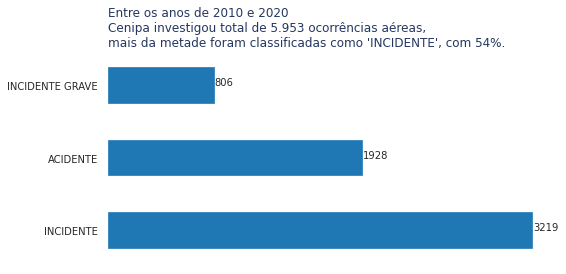

In [24]:
plotbar= df_final.classificacao.value_counts()
fig, ax = plt.subplots(figsize=(8, 4))

plotbar.plot(kind='barh') #, title= "Quantidade por tipo de ocorrência")
for i, v in enumerate(plotbar):
  plt.text(v, i, str(v))
plt.tick_params(
    axis='both',         
    which='both',     
    bottom=False,      
    top=False,         
    labelbottom=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# plotar anotações
plt.text(1, 2.5,
         "Entre os anos de 2010 e 2020\n"
         "Cenipa investigou total de 5.953 ocorrências aéreas, \n"
         "mais da metade foram classificadas como 'INCIDENTE', com 54%."
         ,
         verticalalignment="bottom",
         fontsize=12,
         color='#253760');

In [25]:
# filtro_classificacao = df_final.classificacao

#### 4.5.2 Tipos de Operação - finalidade do voo
Tipo de Operação é a atividade indicada pelo operador da aeronave, quando do ocorrido o evento apurado pelo Cenipa.

<img alt="Imagem" width="25%" src="https://github.com/angeloBuso/Dash_Streamlit_Ocorrencias_Aereas/blob/master/image/aviaca_brasileira.png?raw=true">

Das 6 principais operações identificadas, segue uma breve explicação:

* `PRIVADA` TPP -> aeronaves utilizadas para serviços realizados sem remuneração, em benefício dos proprietários ou operadores, compreendendo as atividades aéreas de recreio ou desportivas, de transporte reservado ao proprietário ou operador, de serviços aéreos especializados realizados em benefício exclusivo do proprietário ou operador, não podendo efetuar quaisquer serviços aéreos remunerados.

* `REGULAR` TPR -> aeronaves utilizadas para serviços de transporte aéreo público, realizado por pessoas jurídicas brasileiras, por concessão e  ediante remuneração, de passageiro, carga ou mala postal, de âmbito regional, nacional ou internacional.

* `INSTRUÇÃO` PRI -> aeronaves utilizadas apenas na instrução, treinamento e adestramento de voo pelos aeroclubes, clubes ou escolas de aviação civil proprietárias ou operadoras da aeronave, podendo ser usada, ainda, para prestar tais serviços à pessoal de outras organizações sob contrato aprovado pela ANAC.

* `TÁXI AÉREO` TPX -> aeronaves utilizadas para serviços de transporte aéreo público não regular de passageiro ou carga, realizados por pessoa natural ou jurídica brasileira, autorizada, mediante remuneração convencionada entre o usuário e o transportador, visando a proporcionar atendimento imediato, independente de horário, percurso ou escala.

* `AGRÍCOLA` SAE-AG -> Serviço Aéreo Especializado Público (SAE), compreendem: fomento ou proteção da agricultura em geral; provocação artificial de chuvas ou modificação de clima.

* `EXPERIMENTAL` PET -> aeronaves visando à certificação na categoria experimental.

In [26]:
(df_final.tipo_operacao.value_counts() / df_final.shape[0])*100

PRIVADA          32.555014
REGULAR          19.922728
INSTRUÇÃO        13.572988
TÁXI AÉREO       12.884260
AGRÍCOLA          8.315135
EXPERIMENTAL      4.905090
***               2.738115
POLICIAL          2.654124
ESPECIALIZADA     1.394255
NÃO REGULAR       1.058290
Name: tipo_operacao, dtype: float64

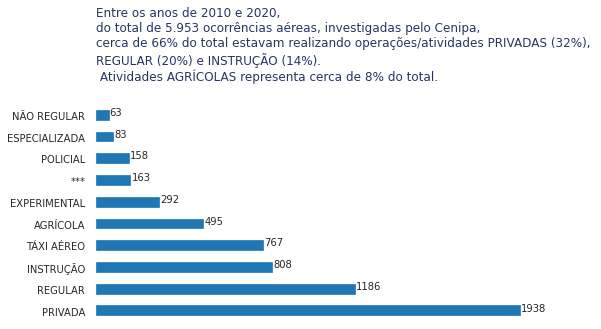

In [27]:
plotbar1 = df_final.tipo_operacao.value_counts()
fig, ax = plt.subplots(figsize=(8, 4))
plotbar1.plot(kind= 'barh')
for i, v in enumerate(plotbar1):
  plt.text(v, i, str(v))
plt.tick_params(
    axis='both',         
    which='both',     
    bottom=False,      
    top=False,         
    labelbottom=False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# plotar anotações
plt.text(0.5, 14,
         "Entre os anos de 2010 e 2020,\n"
         "do total de 5.953 ocorrências aéreas, investigadas pelo Cenipa, \n"
         "cerca de 66% do total estavam realizando operações/atividades PRIVADAS (32%), \n"
         "REGULAR (20%) e INSTRUÇÃO (14%). \n "
         "Atividades AGRÍCOLAS representa cerca de 8% do total."
         ,
         verticalalignment="top",
         fontsize=12,
         color='#253760');

Dentro desses tipos de atividade, as que vieram ter fatalidades são apresentas abaixo:

In [28]:
tabela= df_final.pivot_table(values=['fatalidades'],\
                             index= ['tipo_operacao'], aggfunc= np.sum).\
                             sort_values('fatalidades', ascending= False)
                             
print("Total de fatalidades registradas: ",df_final.fatalidades.sum())
tabela

Total de fatalidades registradas:  882


,fatalidades
tipo_operacao,
PRIVADA,509
EXPERIMENTAL,105
TÁXI AÉREO,94
AGRÍCOLA,81
INSTRUÇÃO,44
POLICIAL,20
REGULAR,16
***,7
ESPECIALIZADA,6


#### 4.5.3 Datas das ocorrências
O formato `dateTime` no atributo `data`, permite fatiarmos por períodos.

De forma rápida identificamos que, entre os anos de 2010 à 2020, os anos que mais teve ocorrências foi entre 2012 e 2013. Usando período de dias do ano civil (365 dias) podemos identificar a média diária de ocorrências aéreas, com médias diárias de 1,86 e 1,81 ocorrências, respectivamente. 

Neste último ano de 2020 a média de ocorrências aéreas diárias foi de 1,50

In [29]:
df_final.data.dt.year.value_counts().sort_index()/365

2010.0    1.567123
2011.0    1.610959
2012.0    1.860274
2013.0    1.816438
2014.0    1.583562
2015.0    1.298630
2016.0    1.139726
2017.0    1.200000
2018.0    1.282192
2019.0    1.441096
2020.0    1.506849
Name: data, dtype: float64

##### 4.5.3.1 Possíveis manipulações com datas
Podemos ainda com o atributo `data` no formato `dataTime` verificar ocorrências mensais, dado um ano específico.

In [30]:
df_2020= df_final[(df_final.data.dt.year == 2020)]
df_2020['mes']= df_2020.data.dt.month
name_mes = {
    1: 'janeiro',
    2: 'fevereiro',
    3: 'março',
    4: 'abril',
    5: 'maio',
    6: 'junho',
    7: 'julho',
    8: 'agosto',
    9: 'setembro',
    10: 'outubro',
    11: 'novembro',
    12: 'dezembro'
}
df_2020['mes'] = df_2020['mes'].map(name_mes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
df_2020.head()

,latitude,longitude,data,classificacao,cidade,uf,aeronaves_envolvidas,tipo,tipo_categoria,tipo_veiculo,registro_segmento,fase_operacao,tipo_operacao,nivel_dano,fatalidades,mes
codigo_ocorrencia,,,,,,,,,,,,,,,,
79043,-22.859722,-46.037500,2020-01-01 21:00:00,ACIDENTE,CAMANDUCAIA,MG,1,PERDA DE CONTROLE NO SOLO,PERDA DE CONTROLE NO SOLO,AVIÃO,PARTICULAR,DECOLAGEM,PRIVADA,SUBSTANCIAL,0,janeiro
79044,-12.908611,-38.322500,2020-03-01 16:35:00,INCIDENTE GRAVE,SALVADOR,BA,1,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO...,AVIÃO,PARTICULAR,DECOLAGEM,PRIVADA,NENHUM,0,março
79044,-12.908611,-38.322500,2020-03-01 16:35:00,INCIDENTE GRAVE,SALVADOR,BA,1,POUSO LONGO,EXCURSÃO DE PISTA | POUSO LONGO,AVIÃO,PARTICULAR,DECOLAGEM,PRIVADA,NENHUM,0,março
79049,-22.137500,-47.256111,2020-03-01 21:15:00,ACIDENTE,LEME,SP,1,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO...,AVIÃO,AGRÍCOLA,DECOLAGEM,AGRÍCOLA,SUBSTANCIAL,0,março
79132,-18.720833,-39.833056,2020-03-01 14:10:00,INCIDENTE,SÃO MATEUS,ES,1,INDETERMINADO,INDETERMINADO,AVIÃO,TÁXI AÉREO,CRUZEIRO,TÁXI AÉREO,NENHUM,0,março


Para o ano de 2020, observamos que o mês de janeiro houve mais ocorrências aéreas, 62 ao longo de todo esse mês. Seguido por dezembro, com 57. O mês com menor número de ocorrência foi em julho, com 29 ocorrências.

Text(0.5, 1.0, 'Ocorrências mensais em 2020')

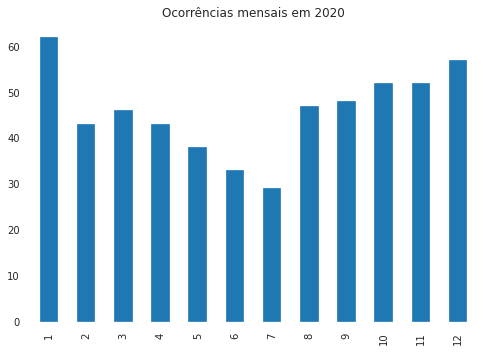

In [32]:
df_2020.data.dt.month.value_counts().sort_index().plot(kind= 'bar');
plt.title("Ocorrências mensais em 2020")

In [33]:
df_2020.mes.value_counts()

janeiro      62
dezembro     57
novembro     52
outubro      52
setembro     48
agosto       47
março        46
abril        43
fevereiro    43
maio         38
junho        33
julho        29
Name: mes, dtype: int64

In [34]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 79043 to 79844
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   latitude              548 non-null    float64       
 1   longitude             548 non-null    float64       
 2   data                  550 non-null    datetime64[ns]
 3   classificacao         550 non-null    object        
 4   cidade                550 non-null    object        
 5   uf                    550 non-null    object        
 6   aeronaves_envolvidas  550 non-null    int64         
 7   tipo                  550 non-null    object        
 8   tipo_categoria        550 non-null    object        
 9   tipo_veiculo          550 non-null    object        
 10  registro_segmento     550 non-null    object        
 11  fase_operacao         550 non-null    object        
 12  tipo_operacao         550 non-null    object        
 13  nivel_dano    

#### 4.5.3 Mapa das ocorrências

Para construir mapas de forma simples e rápida necessitamos de informações da Latitude e Longitude das observações.

Em uma análise preliminar nos dados, constatamos que as informações inputadas nestes atributos estavam totalmente desorganizados. No [repositório do git](https://https://github.com/angeloBuso/Dash_Streamlit_Ocorrencias_Aereas/tree/master/dataSet) identificaremos dois arquivos `ocorrencia_2010_2020.csv` e `ocorrencia_2010_2020_lat_lon_etl.csv`. A diferença entre eles foi o tratamento que damos nos atributos de latitude e longitude.

Em *Data Science* a compreensão dos seus dados é uma das fases mais importantes de todo o projeto. No Brasil ainda estamos caminhando para uma estrutura de *data Open* tanto para as empresas como para os dados disponibilizados pelos Governos.

Para esse processo de **limpeza** nos atributos de `latitude` e `longitude` retiramos:
1.   Valores inseridos como ***;
2.   Como separador de milhar de números decimais no Brasil é representado por "," (vírgula) e em python tal representação se dá por "." (ponto), quando da importação dos dados houve as duas ocorrências, sendo assim, invertemos na base essa notação de milhar, passando todos para "."
1.   Identificamos informações em que haviam mais de 1 "." separando as informações, reflexo da não padronização das informações
2.   Algumas informações não constavam o sinal de "-" (negativo).
1.   Na carga dos dados identificamos valores missing, em uma quantidade elevada. A premissa usada para tratar, foi usar a média. Entretando, percebeu-se que 146 `cidades` possuia apenas 1 registro, ou todos como `NAN`, que inviabilizaria o uso dessa tecnica de **inputação**. Neste caso, após identificar tais ocorrências, preenchemos de forma manual, pesquisando a `latitude` e `longitude` dessas 146 cidades, através de pesquisas na internte dessas informações.


```

cidades= teste1.loc[teste1['ocorrencia_latitude'].isnull()].\
ocorrencia_cidade.value_counts()

MANICORÉ              6
PARNAMIRIM            4
PARINTINS             4
ITAJUBÁ               3
SANTANA DO PARAÍSO    3
                     ..
BAYEUX                1
VERA                  1
PINHEIRO              1
CANTAGALO             1
CAMPINAS DO PIAUÍ     1
Name: ocorrencia_cidade, Length: 146, dtype: int64
```

Após esse processo de **limpeza** os atributos puderam ser reconhecidos como `float` pelo Python. E o próximo passo será tratar os valores missing, com base na premissa assumida.

In [35]:
# tratamos os dados de forma manual. Uma vez, que os dados abertos temos
# problemas de formatado e entrada dos dados 
df_final.latitude.isnull().sum()/df_final.shape[0]

0.3625062993448681

In [36]:
# Forma1: como identificar as cidades que possuem valores missing de ´latitude´
# a. identificando as cidades e a quantidade de nulos em cada
cidades= df_final.loc[df_final['latitude'].isnull()].\
cidade.value_counts()

# b. obetndo os indices (o nome das cidades)
cidades.index.to_list()

# c. usando repetição para cada cidades (indice - step b), itero sobre
# o dataSet, onde a coluna cidade for igual ao indice do step b, acesso 
# a coluna "latitude" peço a média. Gravo em uma lista
cord_fill= []
for i in cidades.index.to_list():
  lat =df_final.loc[df_final.cidade == i].latitude.mean()
  lng= df_final.loc[df_final.cidade == i].longitude.mean()
  cord_fill.append([lat, lng])

# d. agrupo em um novo dataSet
teste2 = pd.DataFrame(cord_fill, index= cidades.index, columns= ['latitude',\
                                                                 'longitude'])
teste2

# e. agora é só usar os valores das médias, na função fillna para inputar nos
# dados originais

# Usando esta forma temos uma tabela com as médias de lat e lng das
# cidades/indices que estão vom valores missing, temos que levar essas
# informações para o dataSet... mais podemos usar o poder computacional para 
# encurtar esses caminhos..

,latitude,longitude
RIO DE JANEIRO,-22.963758,-43.254554
SÃO PAULO,-23.607141,-46.870520
BELO HORIZONTE,-19.896988,-44.059427
GUARULHOS,-23.061785,-46.357671
BRASÍLIA,-15.868780,-47.899136
...,...,...
VERANÓPOLIS,-28.935000,-51.568333
CORUPÁ,-26.430556,-49.277500
MOGI MIRIM,-22.461481,-47.002222
PAULÍNIA,-22.731389,-47.082500


In [37]:
# Forma2: o que estamos fazendo são forma de agrupar por uma coluna, desse
# agrupamento extrair um valor, dado a formula que passamos como paramentro

# a. agrupo e identifico qual métrica busco
media_lat= df_final.groupby('cidade')['latitude'].\
transform('mean')
media_lng= df_final.groupby('cidade')['longitude'].\
transform('mean')

# b. aplico
df_final['latitude'].fillna(media_lat, inplace= True)
df_final['longitude'].fillna(media_lng, inplace= True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [38]:
df_final.head()

,latitude,longitude,data,classificacao,cidade,uf,aeronaves_envolvidas,tipo,tipo_categoria,tipo_veiculo,registro_segmento,fase_operacao,tipo_operacao,nivel_dano,fatalidades
codigo_ocorrencia,,,,,,,,,,,,,,,
40211,-22.963758,-43.254554,2010-03-01 12:00:00,INCIDENTE,RIO DE JANEIRO,RJ,1,TRÁFEGO AÉREO,PERDA DE SEPARAÇÃO / COLISÃO EM VOO | TRÁFEGO ...,HELICÓPTERO,TÁXI AÉREO,DECOLAGEM,TÁXI AÉREO,NENHUM,0
40349,-1.631028,-48.466457,2010-03-01 11:05:00,INCIDENTE,BELÉM,PA,1,COLISÃO COM AVE,COLISÃO COM AVE,AVIÃO,REGULAR,DECOLAGEM,REGULAR,LEVE,0
40351,-22.963758,-43.254554,2010-03-01 03:00:00,INCIDENTE,RIO DE JANEIRO,RJ,1,COLISÃO COM AVE,COLISÃO COM AVE,AVIÃO,REGULAR,INDETERMINADA,REGULAR,LEVE,0
39527,-13.106667,-55.993056,2010-04-01 17:30:00,ACIDENTE,LUCAS DO RIO VERDE,MT,1,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,AVIÃO,PARTICULAR,VOO A BAIXA ALTURA,AGRÍCOLA,SUBSTANCIAL,0
40324,-31.650000,-52.243611,2010-05-01 19:25:00,INCIDENTE,PELOTAS,RS,1,OUTROS,OUTROS,AVIÃO,REGULAR,TÁXI,REGULAR,NENHUM,0


In [39]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5953 entries, 40211 to 79844
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   latitude              5953 non-null   float64       
 1   longitude             5953 non-null   float64       
 2   data                  5952 non-null   datetime64[ns]
 3   classificacao         5953 non-null   object        
 4   cidade                5953 non-null   object        
 5   uf                    5953 non-null   object        
 6   aeronaves_envolvidas  5953 non-null   int64         
 7   tipo                  5953 non-null   object        
 8   tipo_categoria        5953 non-null   object        
 9   tipo_veiculo          5953 non-null   object        
 10  registro_segmento     5953 non-null   object        
 11  fase_operacao         5953 non-null   object        
 12  tipo_operacao         5953 non-null   object        
 13  nivel_dano   

Obtendo um novo dataSet de 2020 após realizar a inputação dos valores missing.

In [40]:
df_2020= df_final[(df_final.data.dt.year == 2020)]
df_2020['mes']= df_2020.data.dt.month
name_mes = {
    1: 'janeiro',
    2: 'fevereiro',
    3: 'março',
    4: 'abril',
    5: 'maio',
    6: 'junho',
    7: 'julho',
    8: 'agosto',
    9: 'setembro',
    10: 'outubro',
    11: 'novembro',
    12: 'dezembro'
}
df_2020['mes'] = df_2020['mes'].map(name_mes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 79043 to 79844
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   latitude              550 non-null    float64       
 1   longitude             550 non-null    float64       
 2   data                  550 non-null    datetime64[ns]
 3   classificacao         550 non-null    object        
 4   cidade                550 non-null    object        
 5   uf                    550 non-null    object        
 6   aeronaves_envolvidas  550 non-null    int64         
 7   tipo                  550 non-null    object        
 8   tipo_categoria        550 non-null    object        
 9   tipo_veiculo          550 non-null    object        
 10  registro_segmento     550 non-null    object        
 11  fase_operacao         550 non-null    object        
 12  tipo_operacao         550 non-null    object        
 13  nivel_dano    

In [42]:
coord= []
for lat, lng in zip(df_2020.latitude.values, df_2020.longitude.values):
  coord.append([lat, lng])

Regiões onde mais se concentrou ocorrências aéreas em 2020.

In [43]:
mapa= folium.Map(location=[-15.788497,-47.879873], zoom_start=4.5, tiles= 'Stamen Toner' )
mapa.add_child(plugins.HeatMap(coord))



---

---





Essas análises estáticas não nos dão **conciência situacional** ao ponto de deixar dinâmico a extração dessas informação.

Com base nessa manipulação que fizemos até aqui vamos dar mais interatividade e **visual** a esses dados.

Usando a biblioteca `Streamlit` construiremos um dashbord com linguagem python.

Vamos lá!

In [44]:
index_coluna = "codigo_ocorrencia"
df1= pd.read_csv(ocorrencia, sep= ';')
df2 = pd.read_csv(aeronave, sep= ';')
df3 = pd.read_csv(ocorrencia_tp, sep= ';')
# a.1 dados combinados
# a.1.1 df1 & df3
dados= pd.merge(df1,df3, how= 'left', on= 'codigo_ocorrencia1')
# a.1.2 df1 & df2
dados= pd.merge(dados, df2, how= 'left', on= 'codigo_ocorrencia2')
# b. feature selection, rename labels e indicação de indice
colunas = {
    'ocorrencia_latitude': 'latitude',
    'ocorrencia_longitude': 'longitude',
    'ocorrencia_dia': 'data',
    'ocorrencia_classificacao': 'classificacao',
    'ocorrencia_cidade': 'cidade',
    'ocorrencia_uf': 'uf',
    'total_aeronaves_envolvidas': 'aeronaves_envolvidas',
    'ocorrencia_tipo': 'tipo',
    'ocorrencia_tipo_categoria': 'tipo_categoria',
    'aeronave_tipo_veiculo': 'tipo_veiculo',
    'aeronave_registro_segmento': 'registro_segmento',
    'aeronave_fase_operacao': 'fase_operacao',
    'aeronave_tipo_operacao': 'tipo_operacao',
    'aeronave_nivel_dano': 'nivel_dano',
    'aeronave_fatalidades_total': 'fatalidades'
}
dados.index = dados[index_coluna]
dados = dados.rename(columns=colunas)
# c. dateTime atributo "data"
dados['data'] = dados['data'] + " " + dados['ocorrencia_hora']
# dados.data = dados.data + " " + dados.ocorrencia_hora
dados.data = pd.to_datetime(dados.data)

# d. tratando informações de lat e long (identificado apenas no final do projeto)
# d.1 agrupo e identifico qual métrica busco
media_lat = dados.groupby('cidade')['latitude'].transform('mean')
media_lng = dados.groupby('cidade')['longitude'].transform('mean')

# d.2  aplico
dados['latitude'].fillna(media_lat, inplace=True)
dados['longitude'].fillna(media_lng, inplace=True)

# e. filtro dataSet pelas feature selection
dados = dados[list(colunas.values())]
df = dados

In [45]:
classifier = df.classificacao.unique().tolist()
classifier

['INCIDENTE', 'ACIDENTE', 'INCIDENTE GRAVE']

In [46]:
md_diaria = round(df.shape[0]/365,2)
fatalidade = df.fatalidades.sum()

In [47]:
md_diaria
fatalidade

882

In [48]:
#uf_filtrado = df.uf.value_counts().sort_index()
segmento_filtrado = df.registro_segmento.value_counts(ascending= False)

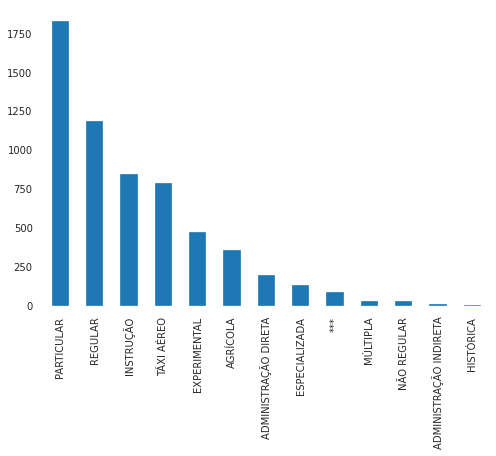

In [49]:
segmento_filtrado.plot.bar();

In [50]:
#df_filtrado14 = df[(df.data.dt.year == 2014) & (df.classificacao.isin(classifier))]

In [51]:
finalidade= pd.DataFrame(df_final.registro_segmento.value_counts()).reset_index()
finalidade

,index,registro_segmento
0,PARTICULAR,1828
1,REGULAR,1184
2,INSTRUÇÃO,843
3,TÁXI AÉREO,784
4,EXPERIMENTAL,470
5,AGRÍCOLA,355
6,ADMINISTRAÇÃO DIRETA,198
7,ESPECIALIZADA,129
8,***,90
9,MÚLTIPLA,32


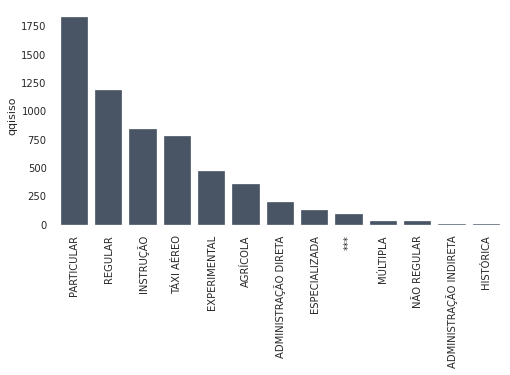

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x= finalidade['index'], y= finalidade['registro_segmento'],
            color= '#44546A', ax= ax)
ax.set_ylabel("qqisiso")
ax.set_xlabel("")
ax.set_xticklabels(finalidade['index'], rotation= 90)
ax.set_title
plt.show()